In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from collections import Counter
from pyspark.sql import functions as F
from pyspark.sql.functions import lower
from pyspark.sql.functions import min, max
from pyspark.sql.functions import col, regexp_extract, when
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import expr
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector

scala_version = '2.12'
spark_version = '3.5.1'
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:3.7.0'
]

spark = SparkSession.builder.master("local").appName("Spark-Cleaning").config("spark.jars.packages", ",".join(packages)).getOrCreate()

In [2]:
spark

In [3]:
file_path = "amazon_products.csv"  # Update with the correct path
spark_df = spark.read.option("header", "true").csv(file_path)
spark_df.show()

+--------------------+-------+---------+--------------------+------------------+-------+--------------------+-------------+------------------------------+-------------------------+----------------------+------------------------------+-------------------------------+--------------------------+----------------------------+-------------------------+------------------------+--------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+---------------------+--------------------------------+--------------------------+-----------------+------------------------+------------------------+---------------+--------------------+-----------+---------------------+-----------------+----------------------------------+----------------------+-------------------------+------------------+-----------------------------------------+----------+-------------------+--------------------------------+------------------+-----------------+--------

In [4]:
spark_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- price: string (nullable = true)
 |-- old_price: string (nullable = true)
 |-- product_url: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- purchases: string (nullable = true)
 |-- detail_brand: string (nullable = true)
 |-- detail_memory_storage_capacity: string (nullable = true)
 |-- detail_hardware_interface: string (nullable = true)
 |-- detail_special_feature: string (nullable = true)
 |-- detail_connectivity_technology: string (nullable = true)
 |-- detail_digital_storage_capacity: string (nullable = true)
 |-- detail_hard_disk_interface: string (nullable = true)
 |-- detail_hard_disk_description: string (nullable = true)
 |-- detail_compatible_devices: string (nullable = true)
 |-- detail_installation_type: string (nullable = true)
 |-- detail_read_speed: string (nullable = true)
 |-- detail_write_speed: string (nullable = true)
 |-- detail_style: string (nullable = true)
 |-

In [5]:
def spark_info(df, abbreviate_columns=True, include_nested_types=False, count=None):
    classinfo = "<class 'pyspark.sql.dataframe.DataFrame'>"

    _cnt = count if count else df.count()
    numrows = f"Total Rows: {str(_cnt)}"

    _cols = (
        ', to '.join([
            df.columns[0], df.columns[-1]]) 
        if abbreviate_columns 
        else ', '.join(df.columns))
    columns = f"{len(df.columns)} entries: {_cols}"

    _typs = [
        col.dataType 
        for col in df.schema 
        if include_nested_types or (
            'ArrayType' not in str(col.dataType) and 
            'StructType' not in str(col.dataType) and
            'MapType' not in str(col.dataType))
    ]
    dtypes = ', '.join(
        f"{str(typ)}({cnt})" 
        for typ, cnt in Counter(_typs).items())

    mem = f'memory usage: ? bytes'

    return '\n'.join([classinfo, numrows, columns, dtypes, mem])

In [6]:
print(spark_info(spark_df))

<class 'pyspark.sql.dataframe.DataFrame'>
Total Rows: 3740
140 entries: title, to detail_movement_detection_technology
StringType()(140)
memory usage: ? bytes


In [7]:
spark_df = spark_df.drop('detail_no._of_wires')

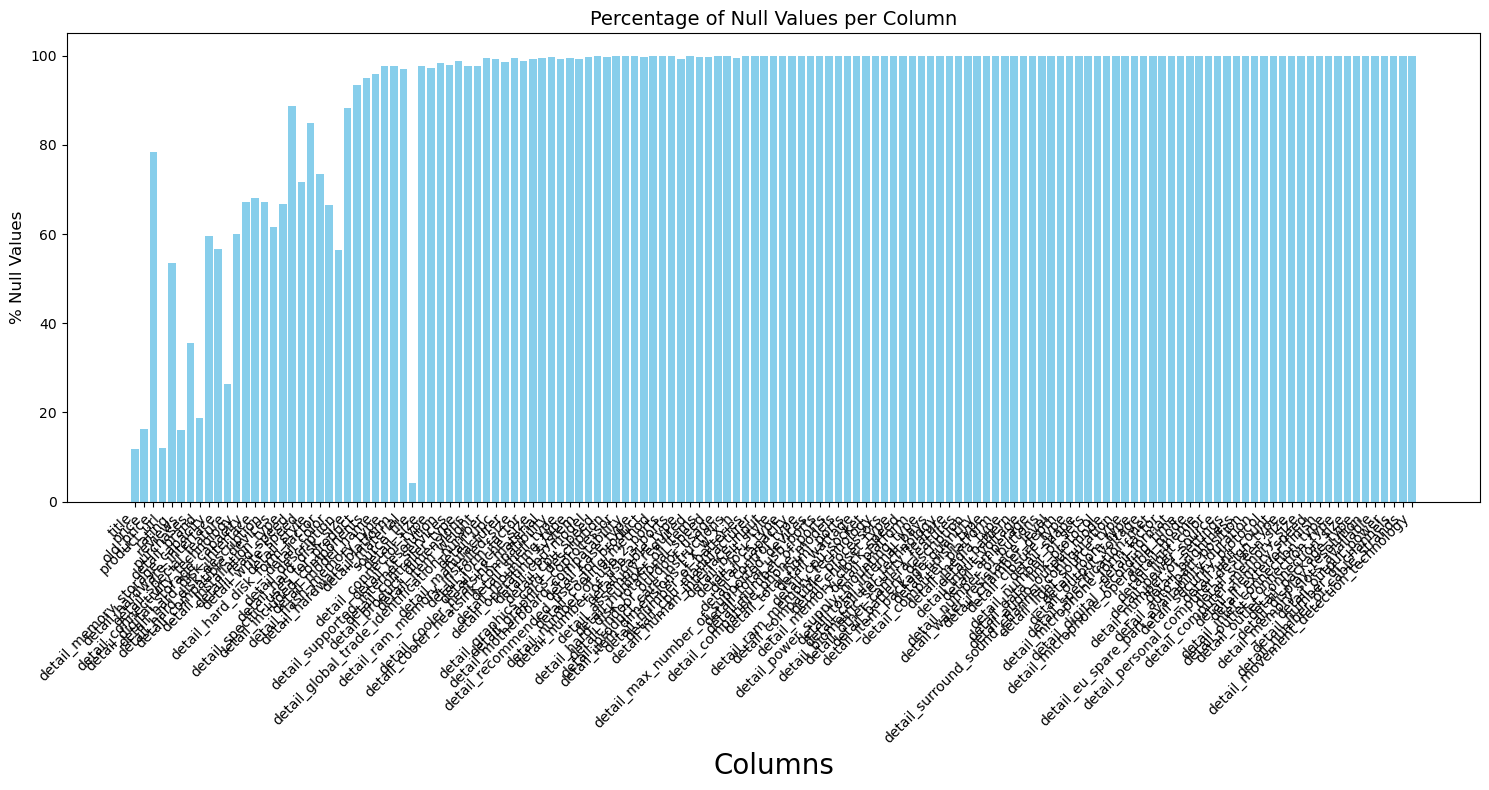

In [8]:
null_percentages = spark_df.select([
    F.round((F.count(F.when(F.col(c).isNull(), 1)) / F.count("*")) * 100, 2).alias(c)
    for c in spark_df.columns
]).first().asDict()

columns = list(null_percentages.keys())
percentages = list(null_percentages.values())

plt.figure(figsize=(15, 8)) 
plt.bar(columns, percentages, color='skyblue')
plt.xlabel('Columns', fontsize=20)  
plt.ylabel('% Null Values', fontsize=12)
plt.title('Percentage of Null Values per Column', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.tight_layout()

plt.show()

In [9]:
columns_to_keep = ["title", "price", "old_price", "rating", "reviews", "purchases", "detail_brand", "detail_memory_storage_capacity", \
                   "detail_hardware_interface", "detail_digital_storage_capacity", "detail_read_speed", "detail_write_speed", "detail_color"]

spark_df = spark_df.select(columns_to_keep)

spark_df.show()

+--------------------+-------+---------+------------------+-------+--------------------+-------------+------------------------------+-------------------------+-------------------------------+--------------------+--------------------+--------------------+
|               title|  price|old_price|            rating|reviews|           purchases| detail_brand|detail_memory_storage_capacity|detail_hardware_interface|detail_digital_storage_capacity|   detail_read_speed|  detail_write_speed|        detail_color|
+--------------------+-------+---------+------------------+-------+--------------------+-------------+------------------------------+-------------------------+-------------------------------+--------------------+--------------------+--------------------+
|                NULL|   NULL|     NULL|              NULL|   NULL|                NULL|         NULL|                          NULL|                     NULL|                           NULL|                NULL|                NULL|  

In [10]:
spark_df = spark_df.withColumnRenamed("detail_brand", "Brand")\
       .withColumnRenamed("detail_memory_storage_capacity", "Memory Storage Capacity")\
       .withColumnRenamed("detail_hardware_interface", "Hardware Interface")\
       .withColumnRenamed("detail_digital_storage_capacity", "Digital Storage Capacity")\
       .withColumnRenamed("detail_read_speed", "Read Speed")\
       .withColumnRenamed("detail_write_speed", "Write Speed")\
       .withColumnRenamed("detail_color", "Color")

spark_df.show()

+--------------------+-------+---------+------------------+-------+--------------------+-------------+-----------------------+------------------+------------------------+--------------------+--------------------+--------------------+
|               title|  price|old_price|            rating|reviews|           purchases|        Brand|Memory Storage Capacity|Hardware Interface|Digital Storage Capacity|          Read Speed|         Write Speed|               Color|
+--------------------+-------+---------+------------------+-------+--------------------+-------------+-----------------------+------------------+------------------------+--------------------+--------------------+--------------------+
|                NULL|   NULL|     NULL|              NULL|   NULL|                NULL|         NULL|                   NULL|              NULL|                    NULL|                NULL|                NULL|                NULL|
|MFi Certified 256...| $39.99|     NULL|              NULL|     

In [11]:
# `price` và `old_price` 
# Xóa dấu $ và đổi sang float cho tính toán, trong trường hợp old price không có thì sẽ điền = price
spark_df = spark_df.withColumn("price", F.regexp_replace("price", r'[\$,]', '').cast("float")) \
                   .withColumn("old_price", F.when(F.col("old_price").isNull(), F.col("price"))
                               .otherwise(F.regexp_replace("old_price", r'[\$,]', '').cast("float")))

# `rating`
# Thay đổi dạng rating
spark_df = spark_df.withColumn("rating", 
                               F.when(F.col("rating").isNotNull(), 
                                      F.regexp_extract("rating", r"(\d\.\d)", 1).cast("float"))
                               .otherwise(F.lit(0.0)))

spark_df.select('title', 'price', 'old_price', 'rating').show()

+--------------------+------+---------+-----------------+
|               title| price|old_price|           rating|
+--------------------+------+---------+-----------------+
|                NULL|  NULL|     NULL|              0.0|
|MFi Certified 256...| 39.99|    39.99|              0.0|
|fanxiang 256GB Fl...| 36.99|    39.99|              0.0|
|ThePhotoStick® Om...| 92.96|   149.99|              0.0|
|Seagate Portable ...| 69.99|    79.99|4.599999904632568|
|SAMSUNG 990 PRO S...|169.86|   249.99|              0.0|
|Seagate Storage E...|199.99|   359.99|4.599999904632568|
|                NULL|  NULL|     NULL|              0.0|
|SAMSUNG 980 PRO S...| 169.0|   198.75|              0.0|
|SAMSUNG 990 EVO S...|  73.0|   149.99|4.699999809265137|
|SanDisk 4TB Extre...|259.99|   359.99|4.599999904632568|
|WD_BLACK 2TB SN85...|149.99|   189.99|              0.0|
|SAMSUNG T7 Shield...|271.86|   499.99|4.699999809265137|
|Western Digital W...|119.99|   159.99|              0.0|
|             

In [12]:
# `reviews`
# Đổi số lượng review thânhf số
spark_df = spark_df.withColumn("reviews", 
                               F.when(F.col("reviews").isNotNull(), 
                                      F.regexp_replace(F.col("reviews"), ",", "").cast("int"))
                               .otherwise(F.lit(0)))

# `purchases` 
# Lấy thông tin cần thiết từ chuỗi và biến đổi thành integer
spark_df = spark_df.withColumn("purchases",
                               F.when(F.col("purchases").rlike(r"(\d+K?)\+ bought in past month"),
                                      F.regexp_replace(F.regexp_extract(F.col("purchases"), r"(\d+K?)", 1), "K", "000")
                                      .cast("int"))
                               .otherwise(F.lit(0)))

spark_df.select('reviews', 'purchases').show()

+-------+---------+
|reviews|purchases|
+-------+---------+
|      0|        0|
|     96|      500|
|    204|        0|
|   2182|     3000|
| 261799|    10000|
|  10202|    10000|
|  23493|    10000|
|      0|        0|
|  39332|    10000|
|   1591|    10000|
|  70295|     9000|
|  22658|    10000|
|  13718|     7000|
|  19165|     9000|
|      0|        0|
|     58|        0|
|    160|       50|
|  13954|      400|
|   5423|     7000|
|  33496|     5000|
+-------+---------+
only showing top 20 rows



In [13]:
Brand_df = spark_df.groupBy("Brand").count()
Brand_df.show(Brand_df.count())

+--------------------+-----+
|               Brand|count|
+--------------------+-----+
|              HUPINS|    1|
|              Thales|    1|
|              OneKey|    1|
|         Accessonico|    2|
|            Garrulax|   14|
|              Flylin|    2|
|             Sanakma|    1|
|              Rpanle|    1|
|              Iomega|    4|
|                QNAP|   22|
|       Omni DataSafe|    1|
|              Hiseeu|    3|
|                VAVA|    1|
|             ELUTENG|    2|
|            Apricorn|   15|
|            KINGDATA|    1|
|                  15|    1|
|                  V7|    1|
|              Acxico|    1|
|      Patriot Memory|   16|
|            THKAILAR|    5|
|          CaSZLUTION|    3|
|            DiliVing|    1|
|              Xegulg|    3|
|                 JJC|    1|
|             RiskOrb|    1|
|             Deal4GO|    1|
|                JEYI|    2|
|             SinLoon|    2|
|            fanxiang|   79|
|             Tianken|    5|
|             

In [14]:
# # Các Brand chấp nhận trong trường hợp phải lấy từ Title
# accepted_brands = ["SAMSUNG", "Seagate", "SanDisk", "Western Digital", "Crucial", "WD", 
#                    "Kingston", "Amazon Basics", "WD_BLACK", "TOSHIBA", "Maxone", "JSL JDTDC",
#                    "fanxiang", "ThePhotoStick", "GIGASTONE", "SSK", "PNY", "K&ZZ", "SK hynix",
#                    "TEAMGROUP", "KingSpec", "SCICNCE", "Aoriher", "Lexar", "Aiibe", "QNAP"]

# # Create `Brand` column: if the value is null, check `title` for accepted brands
# spark_df = spark_df.withColumn("Brand",
#                                F.when(F.col("Brand").isNull(),
#                                        F.coalesce(*[F.when(F.col("title").contains(brand), brand) for brand in accepted_brands], F.lit("others")))
#                                .otherwise(F.col("Brand"))
#                               )

In [15]:
def filter_brands_by_count(df, threshold):
    brand_counts = df.groupBy("Brand").count()
    filtered_brands = brand_counts.filter(F.col("count") > threshold).select("Brand")
    return [row["Brand"] for row in filtered_brands.collect()]

threshold = 10

accepted_brands = filter_brands_by_count(spark_df, threshold)

accepted_brands

['Garrulax',
 'QNAP',
 'Apricorn',
 'Patriot Memory',
 'fanxiang',
 'K&ZZ',
 'LESOGE',
 'MONGERY',
 'TEARMOS',
 'Wooolken',
 'Crucial',
 'Centon',
 'ABLAZE',
 'SABRENT',
 None,
 'Lexar',
 'Fikwot',
 'Dell',
 'SUDEHO',
 'WD_BLACK',
 'Corsair',
 'AreTop',
 'AGECASH A',
 'Kingston',
 'Everything But Stromboli',
 'MDD MAXDIGITALDATA',
 'SCICNCE',
 'KEXIN',
 'mosDART',
 'Nicepicten',
 'CableCreation',
 'ROSPE',
 'OWC',
 'EASTBULL',
 'Verbatim',
 'PNY',
 'ThePhotoStick',
 'Netac',
 'JSL JDTDC',
 'iStorage',
 'FOTN',
 'Aiibe',
 'Western Digital',
 '$26.99',
 'iDiskk',
 'WD',
 'Synology',
 'Timetec',
 'Aoriher',
 'TOSHIBA',
 'Avolusion',
 'SanDisk',
 'Transcend',
 'JBOS',
 'leizhan',
 'SAMSUNG',
 'Seagate',
 'Gigastone',
 'SSK',
 'Generic']

In [16]:
# Xử lý Brand
spark_df = spark_df.withColumn(
    "Brand",
    F.coalesce(
        *[
            F.when(F.col("title").contains(brand), brand)
            for brand in accepted_brands
        ],
        F.lit("others"),
        F.col("Brand")
    )
)

#Chuẩn hóa lowercase
spark_df = spark_df.withColumn("Brand", lower(spark_df["Brand"]))
spark_df.select('Brand').show(spark_df.count())

+--------------------+
|               Brand|
+--------------------+
|              others|
|              others|
|            fanxiang|
|       thephotostick|
|             seagate|
|             samsung|
|             seagate|
|              others|
|             samsung|
|             samsung|
|             sandisk|
|            wd_black|
|             samsung|
|            wd_black|
|              others|
|           jsl jdtdc|
|              others|
|              others|
|            wd_black|
|             samsung|
|             crucial|
|       thephotostick|
|             crucial|
|              others|
|              others|
|             sandisk|
|                  wd|
|              others|
|              others|
|             sandisk|
|                  wd|
|             sandisk|
|             sandisk|
|              others|
|              others|
|       thephotostick|
|              others|
|              others|
|              others|
|              others|
|          

In [17]:
spark_df.select('Memory Storage Capacity', 'Digital Storage Capacity').show()

+-----------------------+------------------------+
|Memory Storage Capacity|Digital Storage Capacity|
+-----------------------+------------------------+
|                   NULL|                    NULL|
|                 256 GB|                    NULL|
|                   NULL|                  256 GB|
|                 256 GB|                    NULL|
|                   NULL|                    2 TB|
|                   NULL|                    2 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    NULL|
|                   NULL|                    2 TB|
|                   NULL|                    1 TB|
|                   NULL|                    4 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    4 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    NULL|
|                 256 GB|                    NULL|
|                   NULL|      

In [18]:
# Xác định Pattern cho USB và SSD, HDD
usb_pattern = r"(?i)\bUSB\b"
ssd_patterns = r"(?i)\bSSD\b|\bSolid State Drive\b|\bPortable External Hard Drive\b|\bHDD\b"

# Lấy chỉ số dữ liệu Storage Capacity từ title nếu dữ liệu bị thiếu
# Memory Storage Capacity cho USB và Digital Sotage Capacity cho SSD, HDD Portalable External Hard Drive
spark_df = (
    spark_df
    .withColumn(
        "Memory Storage Capacity",
        F.when(
            F.col("Memory Storage Capacity").isNull() & F.col("title").rlike(usb_pattern),
            F.regexp_extract(F.col("title"), r"(\d+(?:\.\d+)?\s?(TB|GB|MB))", 0)
        ).otherwise(F.col("Memory Storage Capacity"))
    )
    .withColumn(
        "Digital Storage Capacity",
        F.when(
            F.col("Digital Storage Capacity").isNull() & F.col("title").rlike(ssd_patterns),
            F.regexp_extract(F.col("title"), r"(\d+(?:\.\d+)?\s?(TB|GB|MB))", 0)
        ).otherwise(F.col("Digital Storage Capacity"))
    )
)

spark_df.select('Memory Storage Capacity', 'Digital Storage Capacity').show()

+-----------------------+------------------------+
|Memory Storage Capacity|Digital Storage Capacity|
+-----------------------+------------------------+
|                   NULL|                    NULL|
|                 256 GB|                    NULL|
|                  256GB|                  256 GB|
|                 256 GB|                    NULL|
|                    2TB|                    2 TB|
|                   NULL|                    2 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    NULL|
|                   NULL|                    2 TB|
|                   NULL|                    1 TB|
|                    4TB|                    4 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    4 TB|
|                   NULL|                 2000 GB|
|                   NULL|                    NULL|
|                 256 GB|                    NULL|
|                    1TB|      

In [19]:
# Xóa các khoảng trống dư thừa giữa giá trị và đơn vị
spark_df = spark_df.withColumn(
    "Memory Storage Capacity",
    F.regexp_replace(F.col("Memory Storage Capacity"), "\\s+", "")
).withColumn(
    "Digital Storage Capacity",
    F.regexp_replace(F.col("Digital Storage Capacity"), "\\s+", "")
)

# Đẩy giá trị 0 vào các cột trống
spark_df = spark_df.fillna("0", subset=["Memory Storage Capacity", "Digital Storage Capacity"])

In [20]:
unit_multiplier = {
    "TB": 1024,
    "GB": 1,
    "MB": 1/1024
}

# Thêm cột mới cho phần giá trị
spark_df = spark_df \
            .withColumn("numeric_value", regexp_extract(col("Digital Storage Capacity"), r"(\d+\.?\d*)", 1)
            .cast("float"))

# Thêm cột mới cho phần 
spark_df = spark_df\
            .withColumn("unit", regexp_extract(col("Digital Storage Capacity"), r"([A-Za-z]+)", 1))

# Chuẩn hóa sang dạng GB
spark_df = spark_df.withColumn(
    "Digital Storage Capacity (GB)",
     when(col("numeric_value") == 0, 0)
    .when(col("unit") == "TB", col("numeric_value") * unit_multiplier["TB"])
    .when(col("unit") == "GB", col("numeric_value") * unit_multiplier["GB"])
    .when(col("unit") == "MB", col("numeric_value") * unit_multiplier["MB"])
    .otherwise(None) 
)

spark_df.select('Digital Storage Capacity', 'Digital Storage Capacity (GB)').show()

+------------------------+-----------------------------+
|Digital Storage Capacity|Digital Storage Capacity (GB)|
+------------------------+-----------------------------+
|                       0|                          0.0|
|                       0|                          0.0|
|                   256GB|                        256.0|
|                       0|                          0.0|
|                     2TB|                       2048.0|
|                     2TB|                       2048.0|
|                  2000GB|                       2000.0|
|                       0|                          0.0|
|                     2TB|                       2048.0|
|                     1TB|                       1024.0|
|                     4TB|                       4096.0|
|                  2000GB|                       2000.0|
|                     4TB|                       4096.0|
|                  2000GB|                       2000.0|
|                       0|     

In [21]:
# Tương tụ cho Memory Storage Capacity
spark_df = spark_df.withColumn("numeric_value_mem", regexp_extract(col("Memory Storage Capacity"), r"(\d+\.?\d*)", 1).cast("float"))
spark_df = spark_df.withColumn("unit_mem", regexp_extract(col("Memory Storage Capacity"), r"([A-Za-z]+)", 1))
spark_df = spark_df.withColumn(
    "Memory Storage Capacity (GB)",
    when(col("numeric_value_mem") == 0, 0)  # Keep zero values unchanged
    .when(col("unit_mem") == "TB", col("numeric_value_mem") * unit_multiplier["TB"])
    .when(col("unit_mem") == "GB", col("numeric_value_mem") * unit_multiplier["GB"])
    .when(col("unit_mem") == "MB", col("numeric_value_mem") * unit_multiplier["MB"])
    .otherwise(None)
)

# Bỏ các cột không cần thiết
spark_df = spark_df.drop("numeric_value", "unit", "numeric_value_mem", "unit_mem", "Digital Storage Capacity", "Memory Storage Capacity")

In [22]:
spark_df.select('Memory Storage Capacity (GB)', 'Digital Storage Capacity (GB)').show()

+----------------------------+-----------------------------+
|Memory Storage Capacity (GB)|Digital Storage Capacity (GB)|
+----------------------------+-----------------------------+
|                         0.0|                          0.0|
|                       256.0|                          0.0|
|                       256.0|                        256.0|
|                       256.0|                          0.0|
|                      2048.0|                       2048.0|
|                         0.0|                       2048.0|
|                         0.0|                       2000.0|
|                         0.0|                          0.0|
|                         0.0|                       2048.0|
|                         0.0|                       1024.0|
|                      4096.0|                       4096.0|
|                         0.0|                       2000.0|
|                         0.0|                       4096.0|
|                       

In [23]:
# 'Hardware Interface pattern
hardware_interfaces = ["USB 3.0", "USB", "USB 3.2 Gen 1", "USB 2.0", "USB 3.2 Gen 2", "3.2 USB"]

# Xóa ',' và tạo cột mới temp_tile để sử dụng cho extract hardware_interfaces
spark_df = spark_df.withColumn("temp_title", F.regexp_replace(F.col("title"), "[,]", ""))

hardware_interface_expr = F.coalesce(
    *[F.when(F.col("temp_title").contains(interface), interface) for interface in hardware_interfaces],
    F.lit("USB")  
)

# Hardware Interface
spark_df = spark_df.withColumn(
    "Hardware Interface",
    F.when(F.col("Hardware Interface").isNull(), hardware_interface_expr)
    .otherwise(F.col("Hardware Interface"))
)

# Re-check cho các trường hợp sai dữ liệu, set default là USB nếu không phù hợp pattern
spark_df = spark_df.withColumn(
    "Hardware Interface",
    F.when(
        # If Hardware Interface is still null or doesn’t match any known hardware interface
        (F.col("Hardware Interface").isNull()) |
        (~F.col("Hardware Interface").isin(hardware_interfaces)),
        # Then re-run extraction or set default
        F.coalesce(
            *[F.when(F.col("temp_title").contains(interface), interface) for interface in hardware_interfaces],
            F.lit("USB")
        )
    ).otherwise(F.col("Hardware Interface"))
)

In [24]:
spark_df.select('temp_title', 'Hardware Interface').show(truncate = True, n = 67)

+--------------------+------------------+
|          temp_title|Hardware Interface|
+--------------------+------------------+
|                NULL|               USB|
|MFi Certified 256...|               USB|
|fanxiang 256GB Fl...|               USB|
|ThePhotoStick® Om...|               USB|
|Seagate Portable ...|           USB 3.0|
|SAMSUNG 990 PRO S...|               USB|
|Seagate Storage E...|               USB|
|                NULL|               USB|
|SAMSUNG 980 PRO S...|               USB|
|SAMSUNG 990 EVO S...|               USB|
|SanDisk 4TB Extre...|               USB|
|WD_BLACK 2TB SN85...|               USB|
|SAMSUNG T7 Shield...|               USB|
|Western Digital W...|               USB|
|                NULL|               USB|
|JSL JDTDC 256GB 3...|               USB|
|1TB External SSD ...|               USB|
|MOSDART 64GB USB ...|           USB 2.0|
|WD_BLACK 2TB SN85...|               USB|
|SAMSUNG T7 Portab...|               USB|
|Crucial P3 Plus 4...|            

In [25]:
spark_df = spark_df.drop("temp_title")

In [26]:
# Pattern cho Write Speed
write_speed_pattern = r"(\d{1,3}(?:,\d{3})*(?:\.\d+)?)(?=\s?(MB/s|Megabytes Per Second|MB per second))"

# Xử lý Write Speed
spark_df = spark_df.withColumn(
    "Write Speed",
    F.when(
        F.col("Write Speed").rlike(write_speed_pattern),
        F.regexp_replace(F.regexp_extract(F.col("Write Speed"), write_speed_pattern, 1), ",", "").cast("float")
    ).when(
        F.col("title").rlike(write_speed_pattern),
        F.regexp_replace(F.regexp_extract(F.col("title"), write_speed_pattern, 1), ",", "").cast("float")
    ).otherwise(F.lit(0))
)

spark_df.select('title', 'Write Speed').show(truncate = True)

+--------------------+-----------+
|               title|Write Speed|
+--------------------+-----------+
|                NULL|        0.0|
|MFi Certified 256...|        0.0|
|fanxiang 256GB Fl...|      490.0|
|ThePhotoStick® Om...|        0.0|
|Seagate Portable ...|        0.0|
|SAMSUNG 990 PRO S...|     7450.0|
|Seagate Storage E...|        0.0|
|                NULL|        0.0|
|SAMSUNG 980 PRO S...|        0.0|
|SAMSUNG 990 EVO S...|     5000.0|
|SanDisk 4TB Extre...|       50.0|
|WD_BLACK 2TB SN85...|     7300.0|
|SAMSUNG T7 Shield...|       50.0|
|Western Digital W...|     5150.0|
|                NULL|        0.0|
|JSL JDTDC 256GB 3...|        0.0|
|1TB External SSD,...|        0.0|
|MOSDART 64GB USB ...|        0.0|
|WD_BLACK 2TB SN85...|     7300.0|
|SAMSUNG T7 Portab...|     1050.0|
+--------------------+-----------+
only showing top 20 rows



In [27]:
# Xử lý Read Speed
read_speed_pattern = r"(\d{1,3}(?:,\d{3})*(?:\.\d+)?)(?=\s?(MB/s|Megabytes Per Second|MB per second))"

spark_df = spark_df.withColumn(
    "Read Speed",
    F.when(
        F.col("Read Speed").rlike(read_speed_pattern),
        F.regexp_replace(F.regexp_extract(F.col("Read Speed"), read_speed_pattern, 1), ",", "").cast("float")
    ).otherwise(F.col("Write Speed"))  # Sử dụng Write Speed trong trường hợp không có giá trị
)

In [28]:
spark_df.select('title', 'Read Speed').show(truncate = True)

+--------------------+----------+
|               title|Read Speed|
+--------------------+----------+
|                NULL|       0.0|
|MFi Certified 256...|       0.0|
|fanxiang 256GB Fl...|     560.0|
|ThePhotoStick® Om...|     350.0|
|Seagate Portable ...|       0.0|
|SAMSUNG 990 PRO S...|    7450.0|
|Seagate Storage E...|       0.0|
|                NULL|       0.0|
|SAMSUNG 980 PRO S...|       0.0|
|SAMSUNG 990 EVO S...|    5000.0|
|SanDisk 4TB Extre...|      50.0|
|WD_BLACK 2TB SN85...|    7300.0|
|SAMSUNG T7 Shield...|      50.0|
|Western Digital W...|    5150.0|
|                NULL|       0.0|
|JSL JDTDC 256GB 3...|       0.0|
|1TB External SSD,...|       0.0|
|MOSDART 64GB USB ...|       0.0|
|WD_BLACK 2TB SN85...|    7300.0|
|SAMSUNG T7 Portab...|    1050.0|
+--------------------+----------+
only showing top 20 rows



In [29]:
spark_df.select('title', 'Color').show(truncate = True)

+--------------------+--------------------+
|               title|               Color|
+--------------------+--------------------+
|                NULL|                NULL|
|MFi Certified 256...|                NULL|
|fanxiang 256GB Fl...|                NULL|
|ThePhotoStick® Om...|                NULL|
|Seagate Portable ...|               Black|
|SAMSUNG 990 PRO S...|Information Not A...|
|Seagate Storage E...|               Black|
|                NULL|                NULL|
|SAMSUNG 980 PRO S...|               Black|
|SAMSUNG 990 EVO S...|               Black|
|SanDisk 4TB Extre...|               Black|
|WD_BLACK 2TB SN85...|               Black|
|SAMSUNG T7 Shield...|               Black|
|Western Digital W...|               Black|
|                NULL|                NULL|
|JSL JDTDC 256GB 3...|                NULL|
|1TB External SSD,...|          Space Gray|
|MOSDART 64GB USB ...|                NULL|
|WD_BLACK 2TB SN85...|               Black|
|SAMSUNG T7 Portab...|          

In [30]:
Color_df = spark_df.groupBy("Color").count()
Color_df.show(Color_df.count())

+--------------------+-----+
|               Color|count|
+--------------------+-----+
|         NAS SSD 4TB|    1|
|         Black / Red|    1|
|          512gb pink|    3|
|                 RED|    1|
|           Dark Grey|    3|
|PCIe Gen4 NVMe SS...|    1|
|disk; disc; stora...|    1|
|     "2.5""/7mm SSD"|    1|
|           Aluminium|    1|
|Gaming Console, C...|   12|
|  Dark Grayish Brown|    1|
|       Silvery white|    1|
|Black NVME 2230 t...|    1|
|                 Z2S|    1|
|              orange|    3|
|  NAS SSD 2TB 2-Pack|    1|
|          2.5 Inches|    4|
|               BLACK|    6|
|Old Generation Su...|    2|
|PCIe Gen4 NVMe SS...|    1|
|   ZR | RGB Lighting|    5|
|NV7000 | Metal ra...|    1|
|     1TB USB 3.2 1PK|    1|
|    Game Pro SSD 1TB|    1|
|                grey|    1|
|               green|    1|
|              Orange|    3|
|            M.2 2280|    1|
|           Iron Gray|    1|
|1.Black outer+gra...|    1|
| Portable Secure SSD|    1|
|PCIe Gen4 NVM

In [31]:
color_pattern = r"(?i)(Black|White|Gray|Red|Blue|Green|Yellow|Pink|Silver|Gold)" # Thêm nếu cần

# Xử lý cho trường hợp đã có dữ liệu
# Thêm nếu cần
accepted_colors = ["Black", "White", "Gray", "Red", "Blue", "Green", "Yellow", "Pink", 
                   "Silver", "Gold", "Space Gray", "Titan Gray", "Champagne Gold", "Brown", "multi-color"]

# `Color` 
spark_df = spark_df.withColumn(
    "Color",
    F.when(
        F.col("Color").isNull() & F.col("title").rlike(color_pattern),  # Lấy dữ liệu từ Title nếu Color NULL
        F.lower(F.regexp_extract(F.col("title"), color_pattern, 1))  # Chuẩn hóa lowercase
    ).when(
        F.col("Color").isNull(),  # Trong trường hợp Title không có, thế = "others"
        F.lit("others")
    ).when(
        ~F.col("Color").isin(accepted_colors),  # Nếu dữ liệu có sẵn không phù hợp pattern thì thế = "others"
        F.lit("others")
    ).otherwise(
        F.lower(F.col("Color"))  # Nếu hợp thì chuẩn hóa
    )
)

In [32]:
Color_df = spark_df.groupBy("Color").count()
Color_df.show(Color_df.count())

+--------------+-----+
|         Color|count|
+--------------+-----+
|         green|   46|
|        yellow|    1|
|champagne gold|    1|
|        silver|  220|
|         white|   60|
|          gray|   15|
|        others| 2166|
|          pink|   80|
|           red|  111|
|          gold|   25|
|   multi-color|    5|
|    titan gray|    2|
|         black|  829|
|         brown|    1|
|    space gray|    9|
|          blue|  169|
+--------------+-----+



In [33]:
spark_df.select('title', 'Color').show(truncate = True)

+--------------------+----------+
|               title|     Color|
+--------------------+----------+
|                NULL|    others|
|MFi Certified 256...|      pink|
|fanxiang 256GB Fl...|    others|
|ThePhotoStick® Om...|    others|
|Seagate Portable ...|     black|
|SAMSUNG 990 PRO S...|    others|
|Seagate Storage E...|     black|
|                NULL|    others|
|SAMSUNG 980 PRO S...|     black|
|SAMSUNG 990 EVO S...|     black|
|SanDisk 4TB Extre...|     black|
|WD_BLACK 2TB SN85...|     black|
|SAMSUNG T7 Shield...|     black|
|Western Digital W...|     black|
|                NULL|    others|
|JSL JDTDC 256GB 3...|    others|
|1TB External SSD,...|space gray|
|MOSDART 64GB USB ...|    others|
|WD_BLACK 2TB SN85...|     black|
|SAMSUNG T7 Portab...|titan gray|
+--------------------+----------+
only showing top 20 rows



In [34]:
#from pyspark.sql.functions import to_json, struct

# Convert each row in DataFrame to a JSON string
#kafka_df = spark_df.select(to_json(struct(*spark_df.columns)).alias("value"))

# Kafka configurations
#kafka_bootstrap_servers = "localhost:9092"  
#kafka_topic = "BigData"         

#kafka_df.write \
#    .format("kafka") \
#    .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \ #A
#    .option("topic", kafka_topic) \
#    .save()

In [35]:
spark_df = spark_df.dropDuplicates()
spark_df = spark_df.na.drop()
spark_df.show()

+--------------------+-------+---------+-----------------+-------+---------+---------------+------------------+----------+-----------+------+-----------------------------+----------------------------+
|               title|  price|old_price|           rating|reviews|purchases|          Brand|Hardware Interface|Read Speed|Write Speed| Color|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|
+--------------------+-------+---------+-----------------+-------+---------+---------------+------------------+----------+-----------+------+-----------------------------+----------------------------+
|JSL JDTDC 256GB 3...|  89.99|   109.99|4.300000190734863|     58|        0|      jsl jdtdc|               USB|       0.0|        0.0|others|                          0.0|                       256.0|
|USB C Flash Drive...|  27.99|    29.39|4.300000190734863|     47|      100|       wooolken|           USB 2.0|      18.0|        0.0|others|                          0.0|                        1

In [36]:
print(spark_info(spark_df))

<class 'pyspark.sql.dataframe.DataFrame'>
Total Rows: 1936
13 entries: title, to Memory Storage Capacity (GB)
StringType()(4), FloatType()(4), DoubleType()(3), IntegerType()(2)
memory usage: ? bytes


In [37]:
output_path = "C:\\TEMPDATA"
spark_df.write.csv(output_path, 
                   mode="overwrite",
                   header=True)

spark_df.coalesce(1).write.csv("Raw_Processed_Data.csv", mode="overwrite", header=True)

In [38]:
# Các feature cần sử dụng MinMaxScaler
numerical_features = ["price", "old_price", "rating", "reviews", 
                      "purchases", "Write Speed", "Read Speed", 
                      "Digital Storage Capacity (GB)", "Memory Storage Capacity (GB)"]

for feature in numerical_features:
    window_spec = Window.partitionBy()
    
    # Tính toán min, max thông qua Window
    spark_df = spark_df.withColumn("feature_min", min(col(feature)).over(window_spec))
    spark_df = spark_df.withColumn("feature_max", max(col(feature)).over(window_spec))
    
    # Áp dụng MinMaxScaler lên cột features
    spark_df = spark_df.withColumn(
        feature,
        F.when((col("feature_max") - col("feature_min")) != 0,
               (col(feature) - col("feature_min")) / (col("feature_max") - col("feature_min"))
              ).otherwise(lit(0))
    )
    
    # Drop các cột tạm
    spark_df = spark_df.drop("feature_min", "feature_max")

# Loop qua các features
# for feature in numerical_features:
#     # Tìm min và max của feature đó
#     feature_min = spark_df.select(min(col(feature))).first()[0]
#     feature_max = spark_df.select(max(col(feature))).first()[0]

#     # Kiểm tra tránh trường hợp chia 0
#     if feature_max - feature_min != 0:
#         # Áp dụng thuật toán MinMax
#         spark_df = spark_df.withColumn(
#             feature,
#             (col(feature) - feature_min) / (feature_max - feature_min)
#         )
#     else:
#         # Trường hợp nếu toàn bộ giá trị đều như nhau
#         spark_df = spark_df.withColumn(feature, F.lit(0))

In [39]:
spark_df.select("price", "old_price", "rating", "reviews", "purchases", "Write Speed", "Read Speed", "Digital Storage Capacity (GB)", "Memory Storage Capacity (GB)").show()

+--------------------+--------------------+------------------+--------------------+---------+--------------------+--------------------+-----------------------------+----------------------------+
|               price|           old_price|            rating|             reviews|purchases|         Write Speed|          Read Speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|
+--------------------+--------------------+------------------+--------------------+---------+--------------------+--------------------+-----------------------------+----------------------------+
|0.016664844556739288| 0.02036855495841464|0.9148936947312738|1.978833307176341...|      0.0|                 0.0|                 0.0|                          0.0|        0.001736111111111111|
|0.005183342664759051|0.005442602322233656|0.9148936947312738|1.603537335125656E-4|     0.01|                 0.0|0.001276595744680851|                          0.0|        1.085069444444444...|
|0.014627803835817845|0.0

In [40]:
def one_hot_encode(df, column_name):
    # Do OneHotEncoder của PySpark chỉ hoạt động trên dữ liệu số nên cần hỗ trợ của StringIndexer để đổi
    string_indexer = StringIndexer(inputCol=column_name, outputCol=f"{column_name} Index")
    
    # Áp dụng OneHotEncoder cho mỗi danh mục trong cột
    one_hot_encoder = OneHotEncoder(inputCol=f"{column_name} Index", outputCol=f"{column_name} Encoded")
    
    # Tạo và chạy pipeline
    pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])
    model = pipeline.fit(df)
    
    # Biến đổi dataframe
    df_transformed = model.transform(df)
    
    # Xóa cột Index trung gian (optional)
    # df_transformed = df_transformed.drop(f"{column_name} Index")
    
    return df_transformed

spark_df = one_hot_encode(spark_df, "Color")
spark_df = one_hot_encode(spark_df, "Hardware Interface")
spark_df = one_hot_encode(spark_df, "Brand")

In [41]:
spark_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- old_price: double (nullable = true)
 |-- rating: double (nullable = true)
 |-- reviews: double (nullable = true)
 |-- purchases: double (nullable = true)
 |-- Brand: string (nullable = false)
 |-- Hardware Interface: string (nullable = true)
 |-- Read Speed: double (nullable = true)
 |-- Write Speed: double (nullable = true)
 |-- Color: string (nullable = true)
 |-- Digital Storage Capacity (GB): double (nullable = true)
 |-- Memory Storage Capacity (GB): double (nullable = true)
 |-- Color Index: double (nullable = false)
 |-- Color Encoded: vector (nullable = true)
 |-- Hardware Interface Index: double (nullable = false)
 |-- Hardware Interface Encoded: vector (nullable = true)
 |-- Brand Index: double (nullable = false)
 |-- Brand Encoded: vector (nullable = true)



In [42]:
spark_df.select('Color Index', 'Color Encoded').show(truncate = True)

+-----------+--------------+
|Color Index| Color Encoded|
+-----------+--------------+
|        0.0|(14,[0],[1.0])|
|        0.0|(14,[0],[1.0])|
|        4.0|(14,[4],[1.0])|
|        5.0|(14,[5],[1.0])|
|        1.0|(14,[1],[1.0])|
|        0.0|(14,[0],[1.0])|
|        6.0|(14,[6],[1.0])|
|        0.0|(14,[0],[1.0])|
|        0.0|(14,[0],[1.0])|
|        1.0|(14,[1],[1.0])|
|        1.0|(14,[1],[1.0])|
|        3.0|(14,[3],[1.0])|
|        6.0|(14,[6],[1.0])|
|        0.0|(14,[0],[1.0])|
|        1.0|(14,[1],[1.0])|
|        0.0|(14,[0],[1.0])|
|        5.0|(14,[5],[1.0])|
|        0.0|(14,[0],[1.0])|
|        0.0|(14,[0],[1.0])|
|        0.0|(14,[0],[1.0])|
+-----------+--------------+
only showing top 20 rows



In [43]:
spark_df.select('Brand', 'Brand Index').show(n = 67, truncate = True)

+--------------------+-----------+
|               Brand|Brand Index|
+--------------------+-----------+
|           jsl jdtdc|       40.0|
|            wooolken|       43.0|
|           avolusion|        4.0|
|             scicnce|       35.0|
|            apricorn|       28.0|
|           gigastone|       12.0|
|              others|        0.0|
|           transcend|        9.0|
|                  wd|        6.0|
|           avolusion|        4.0|
|              others|        0.0|
|              others|        0.0|
|             seagate|        2.0|
|     western digital|        5.0|
|              others|        0.0|
|           avolusion|        4.0|
|              others|        0.0|
|              others|        0.0|
|              others|        0.0|
|            eastbull|       23.0|
|             samsung|       17.0|
|           avolusion|        4.0|
|              others|        0.0|
|             corsair|       21.0|
|             scicnce|       35.0|
|              other

In [44]:
columns_to_drop = [
    "Brand",
    "Color",
    "Hardware Interface"
]

spark_df = spark_df.drop(*columns_to_drop)

In [45]:
spark_df = spark_df.withColumn("price", col("price").cast("double")) \
                   .withColumn("old_price", col("old_price").cast("double")) \
                   .withColumn("rating", col("rating").cast("double")) \
                   .withColumn("reviews", col("reviews").cast("double")) \
                   .withColumn("purchases", col("purchases").cast("double")) \
                   .withColumn("Write Speed", col("Write Speed").cast("double")) \
                   .withColumn("Read Speed", col("Read Speed").cast("double")) \
                   .withColumn("Digital Storage Capacity (GB)", col("Digital Storage Capacity (GB)").cast("double")) \
                   .withColumn("Memory Storage Capacity (GB)", col("Memory Storage Capacity (GB)").cast("double")) \
                   .withColumn("Color Index", col("Color Index").cast("double")) \
                   .withColumn("Hardware Interface Index", col("Hardware Interface Index").cast("double")) \
                   .withColumn("Brand Index", col("Brand Index").cast("double")) \

spark_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- old_price: double (nullable = true)
 |-- rating: double (nullable = true)
 |-- reviews: double (nullable = true)
 |-- purchases: double (nullable = true)
 |-- Read Speed: double (nullable = true)
 |-- Write Speed: double (nullable = true)
 |-- Digital Storage Capacity (GB): double (nullable = true)
 |-- Memory Storage Capacity (GB): double (nullable = true)
 |-- Color Index: double (nullable = false)
 |-- Color Encoded: vector (nullable = true)
 |-- Hardware Interface Index: double (nullable = false)
 |-- Hardware Interface Encoded: vector (nullable = true)
 |-- Brand Index: double (nullable = false)
 |-- Brand Encoded: vector (nullable = true)



In [46]:
spark_df.show(n = 67, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+---------------------+------------------+---------------------+---------+---------------------+---------------------+-----------------------------+----------------------------+-----------+---------------+------------------------+--------------------------+-----------+---------------+
|title                                                                                                                                                                                                  |price                |old_price            |rating            |reviews              |purchases|Read Speed           |Write Speed          |Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|Color Index|Color Encoded  |Hardware Interface Index|Hardware Interface Encoded|Brand Index|B

In [47]:
spark_df = spark_df.drop("Color Encoded", "Hardware Interface Encoded", "Brand Encoded")

In [48]:
output_path = "C:\\TEMPDATA\\DataFunction"
spark_df.write.csv(output_path, 
                   mode="overwrite",
                   header=True)

spark_df.coalesce(1).write.csv("Processed_Data.csv", mode="overwrite", header=True)